# Comptage du nombre d'hôtels à Marseille par arrondissement 

### Imports

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import requests
import json
import contextily as ctx
import xyzservices.providers as xyz
import folium
from folium import Choropleth

Géolocalisation des hôtels à Marseille: données fournies par openstreetmap OSM : <https://www.openstreetmap.org/relation/76469>

In [2]:
url = "http://overpass-api.de/api/interpreter"
query = """
[out:json][timeout:25];

rel(76469) -> .b;
.b map_to_area -> .a;

(  	node["tourism"~"hotel"](area.a);   
	way["tourism"~"hotel"](area.a);   
	relation["tourism"~"hotel"](area.a); 
); 
out body center;
"""

réponse = requests.get(url, params={'data': query})

Extraction des données à partir du json

In [3]:
data = réponse.json()['elements']

In [4]:
hotels_json = []
for e in data:
    if e["type"] == "node":
        hotels_json.append({
            "lat": e["lat"],
            "lon": e["lon"],
            "nom": e["tags"].get("name", None)})
    else:
        hotels_json.append({
            "lat": e["center"]["lat"],
            "lon": e["center"]["lon"],
            "nom": e["tags"].get("name", None)})

Création d'un géopandas dataframe

In [5]:
df = pd.DataFrame(hotels_json)

In [6]:
hotels = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), crs=4326)

hotels

,lat,lon,nom,geometry
0,43.247200,5.390424,Best Western,POINT (5.39042 43.2472)
1,43.301277,5.380198,Hôtel Terminus Saint-Charles,POINT (5.3802 43.30128)
2,43.298864,5.381210,New Hotel Select,POINT (5.38121 43.29886)
3,43.247309,5.390009,Ibis Marseille Bonneveine,POINT (5.39001 43.24731)
4,43.254882,5.381761,Golden Tulip - Villa Massalia,POINT (5.38176 43.25488)
...,...,...,...,...
139,43.313140,5.404667,CROWNE PLAZA HOTEL,POINT (5.40467 43.31314)
140,43.310953,5.402938,Appart'hôtel Odalys City Le Dôme,POINT (5.40294 43.31095)
141,43.310153,5.370421,easyHotel Marseille Euromed,POINT (5.37042 43.31015)
142,43.280160,5.351833,Le Petit Nice - Passédat,POINT (5.35183 43.28016)


Pour chaque hôtel, on dispose de sa localisation selon le système de coordonnées : 4326

En ce qui concerne les données géographiques propores aux arrondissements de Marseille, le fichier 'arrondissemenets.geojson' sera utilsé

In [7]:
arrondissements = gpd.read_file("arrondissements.geojson")

In [8]:
arrondissements

,cartodb_id,insee,nom,wikipedia,surf_m2,arrondissement,geometry
0,1461,13209,Marseille 9e Arrondissement,fr:9e arrondissement de Marseille,63283053,13009,"MULTIPOLYGON (((5.39679 43.21216, 5.39712 43.2..."
1,1716,13207,Marseille 7e Arrondissement,fr:7e arrondissement de Marseille,5768126,13007,"MULTIPOLYGON (((5.36996 43.26127, 5.37 43.2626..."
2,2597,13208,Marseille 8e Arrondissement,fr:8e arrondissement de Marseille,19440021,13008,"MULTIPOLYGON (((5.36285 43.20715, 5.36311 43.2..."
3,1637,13201,Marseille 1er Arrondissement,fr:1er arrondissement de Marseille,1778220,13001,"MULTIPOLYGON (((5.37219 43.29868, 5.37179 43.2..."
4,1654,13203,Marseille 3e Arrondissement,fr:3e arrondissement de Marseille,2540497,13003,"MULTIPOLYGON (((5.3749 43.30155, 5.37424 43.30..."
5,2576,13205,Marseille 5e Arrondissement,fr:5e arrondissement de Marseille,2185746,13005,"MULTIPOLYGON (((5.38552 43.29431, 5.38633 43.2..."
6,1645,13202,Marseille 2e Arrondissement,fr:2e arrondissement de Marseille,4987243,13002,"MULTIPOLYGON (((5.36912 43.31672, 5.37053 43.3..."
7,1711,13206,Marseille 6e Arrondissement,fr:6e arrondissement de Marseille,2057703,13006,"MULTIPOLYGON (((5.37214 43.29101, 5.38235 43.2..."
8,1753,13210,Marseille 10e Arrondissement,fr:10e arrondissement de Marseille,10782940,13010,"MULTIPOLYGON (((5.41492 43.29169, 5.41653 43.2..."
9,1802,13213,Marseille 13e Arrondissement,fr:13e arrondissement de Marseille,28007422,13013,"MULTIPOLYGON (((5.41534 43.37883, 5.42449 43.3..."


In [9]:
arrondissements.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

les deux fichiers ont mêmes crs, on peut les fusionner

Ensuite, on fait une jointure des deux tables comme suit: à chaque hôtel, on associe l'arrondissement auquel il appartient, au sens géopgraphique dans l'espace

In [10]:
geo_hotels = gpd.sjoin(hotels, arrondissements[['arrondissement','geometry']], how='inner',predicate='intersects')

In [11]:
geo_hotels

,lat,lon,nom,geometry,index_right,arrondissement
0,43.247200,5.390424,Best Western,POINT (5.39042 43.2472),2,13008
1,43.301277,5.380198,Hôtel Terminus Saint-Charles,POINT (5.3802 43.30128),3,13001
2,43.298864,5.381210,New Hotel Select,POINT (5.38121 43.29886),3,13001
3,43.247309,5.390009,Ibis Marseille Bonneveine,POINT (5.39001 43.24731),2,13008
4,43.254882,5.381761,Golden Tulip - Villa Massalia,POINT (5.38176 43.25488),2,13008
...,...,...,...,...,...,...
139,43.313140,5.404667,CROWNE PLAZA HOTEL,POINT (5.40467 43.31314),11,13004
140,43.310953,5.402938,Appart'hôtel Odalys City Le Dôme,POINT (5.40294 43.31095),11,13004
141,43.310153,5.370421,easyHotel Marseille Euromed,POINT (5.37042 43.31015),4,13003
142,43.280160,5.351833,Le Petit Nice - Passédat,POINT (5.35183 43.28016),1,13007


L'étape suivante: on regroupe par arrondissement et on compte combien y a-t-il d'hôtels

In [12]:
compte_hotels = geo_hotels.assign(nombre=1).groupby('arrondissement',as_index=False).sum(numeric_only=True)[["arrondissement","nombre"]]
compte_hotels

,arrondissement,nombre
0,13001,50
1,13002,16
2,13003,5
3,13004,2
4,13005,2
5,13006,15
6,13007,10
7,13008,19
8,13009,1
9,13010,2


! Dans le 14e arrond. il y a 0 hôtel!

In [13]:
arrondissements_comptés = arrondissements.merge(compte_hotels, on='arrondissement', how='left').fillna(0)

In [14]:
arrondissements_comptés

,cartodb_id,insee,nom,wikipedia,surf_m2,arrondissement,geometry,nombre
0,1461,13209,Marseille 9e Arrondissement,fr:9e arrondissement de Marseille,63283053,13009,"MULTIPOLYGON (((5.39679 43.21216, 5.39712 43.2...",1.0
1,1716,13207,Marseille 7e Arrondissement,fr:7e arrondissement de Marseille,5768126,13007,"MULTIPOLYGON (((5.36996 43.26127, 5.37 43.2626...",10.0
2,2597,13208,Marseille 8e Arrondissement,fr:8e arrondissement de Marseille,19440021,13008,"MULTIPOLYGON (((5.36285 43.20715, 5.36311 43.2...",19.0
3,1637,13201,Marseille 1er Arrondissement,fr:1er arrondissement de Marseille,1778220,13001,"MULTIPOLYGON (((5.37219 43.29868, 5.37179 43.2...",50.0
4,1654,13203,Marseille 3e Arrondissement,fr:3e arrondissement de Marseille,2540497,13003,"MULTIPOLYGON (((5.3749 43.30155, 5.37424 43.30...",5.0
5,2576,13205,Marseille 5e Arrondissement,fr:5e arrondissement de Marseille,2185746,13005,"MULTIPOLYGON (((5.38552 43.29431, 5.38633 43.2...",2.0
6,1645,13202,Marseille 2e Arrondissement,fr:2e arrondissement de Marseille,4987243,13002,"MULTIPOLYGON (((5.36912 43.31672, 5.37053 43.3...",16.0
7,1711,13206,Marseille 6e Arrondissement,fr:6e arrondissement de Marseille,2057703,13006,"MULTIPOLYGON (((5.37214 43.29101, 5.38235 43.2...",15.0
8,1753,13210,Marseille 10e Arrondissement,fr:10e arrondissement de Marseille,10782940,13010,"MULTIPOLYGON (((5.41492 43.29169, 5.41653 43.2...",2.0
9,1802,13213,Marseille 13e Arrondissement,fr:13e arrondissement de Marseille,28007422,13013,"MULTIPOLYGON (((5.41534 43.37883, 5.42449 43.3...",2.0


### Carte chloroplète

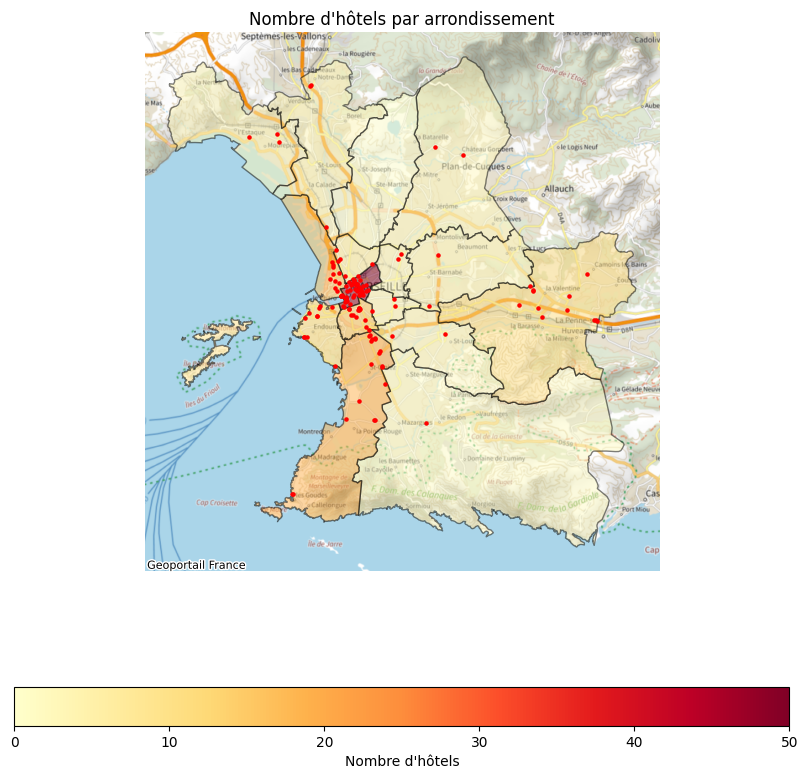

In [15]:
fig , ax = plt.subplots(figsize=(10,10))
ax.set_title("Nombre d'hôtels par arrondissement")
ax.set_axis_off()
arrondissements_comptés.plot(column='nombre',
                            ax=ax,
                            legend=True,
                            legend_kwds={'label': "Nombre d'hôtels",
                                         'orientation': "horizontal"},
                            cmap='YlOrRd',
                            edgecolor='black',
                            alpha=0.5)
                            
hotels.plot(ax=ax, color='red', markersize=5)
ctx.add_basemap(ax, crs="epsg:4326", source=xyz.GeoportailFrance.plan)

plt.show()

### Carte interactive

In [16]:
# la carte doit être centrée sur Marseille
marseille_center = [43.2965, 5.3698]  # Latitude et longitude de Marseille
m = folium.Map(location=marseille_center, zoom_start=12)

In [17]:
Choropleth(
    # arrondissements_comptés est un GeoDataFrame contenant la colonne 'nombre' (nombre d'hôtels)
    geo_data=arrondissements_comptés,
    name='choropleth',
    data=arrondissements_comptés,
    columns=['arrondissement', 'nombre'],  
    key_on='feature.properties.arrondissement',  
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Nombre d'hôtels par arrondissement"
).add_to(m)

In [18]:
# En fin on ajoute les points des hôtels comme Markers
for idx, row in hotels.iterrows():
    folium.Marker(
        location=[row['lat'], row['lon']],  
        popup=f"Nom: {row['nom']}"  
    ).add_to(m)  

In [19]:
# Contrôle des couches
folium.LayerControl().add_to(m)

In [20]:
m